# Response time minimization problem for Oslo

- Goal: Minimize the response time of police vehicles in the city of Oslo, Norway.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.

Previous notebook tested the pipeline for the Øst police district.   
This notebook:
- Modify event simulation to be derived purely from population count, instead of adding randomness. This will make it more reproduceable and easier to compare results. 
- Speed upgrades
- More structured results


In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-03-27T16:04:54.660723+01:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
from descartes import PolygonPatch
import pyproj
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import pulp
import highspy
import folium

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

networkx  : 3.2.1
pandas    : 2.2.1
pulp      : 2.8.0
highspy   : 1.5.3
pandana   : 0.7
shapely   : 2.0.3
pyproj    : 3.6.1
osmnx     : 1.9.1
folium    : 0.16.0
matplotlib: 3.8.3
geopandas : 0.14.3
numpy     : 1.26.4



## 0. Load road network

We load a road network of Øst police district that has been slightly preprocessed.
- Network type: drive
- Akershus and Østfold counties minus Asker, Bærum, Jevnaker and Lunner.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633
- Network already contains edge weights (travel time in seconds)
- Node closeness centrality has already been calculated for the network and stored as a CSV file.

In [3]:
### Load road network file of Øst police district, Norway
# Read from local path
ost_filepath = "../data/ost/OstDriveImputed.graphml" # with travel time attribute
ost_graph = ox.load_graphml(ost_filepath) # originally in WGS84 (EPSG:4326)

In [4]:
ost_graph = ox.projection.project_graph(ost_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of ost_graph: {type(ost_graph)}")
print(f"CRS of ost_graph:  {ost_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(ost_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of ost_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of ost_graph:  EPSG:32633


Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [5]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(ost_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid  \
u         v          key                                      
265629056 8595477415 0    [629271201, 120466454, 926242999]   
          8595512022 0               [926242773, 110781343]   

                                                 name       highway  oneway  \
u         v          key                                                      
265629056 8595477415 0    [Storesandveien, Vadholmen]  unclassified   False   
          8595512022 0                      Storveien       primary   False   

                         reversed   length  \
u         v          key                     
265629056 8595477415 0       True 1061.374   
          8595512022 0      False  435.557   

                                                                   geometry  \
u         v          key                                                      
265629056 8595477415 0    LINESTRING (271942.408 6550299.054, 271939.667...   
          8595512022 0    LINESTRING (271942.408 6550299.054, 271945.319...   

                          speed_kph  travel_time  ref  maxspeed bridge  \
u         v          key                                                 
265629056 8595477415 0       39.800       96.000  NaN       NaN    NaN   
          8595512022 0       50.000       31.400  108  [60, 40]    NaN   

                         junction lanes tunnel width access est_width  
u         v          key                                               
265629056 8595477415 0        NaN   NaN    NaN   NaN    NaN       NaN  
          8595512022 0        NaN   NaN    NaN   NaN    NaN       NaN

## 1. Police car candidate points

Steps:  
1.1 Add Centrality measure as node attribute  
1.2 Sample candidate points and filter out poor candidate points

### 1.1 Add Centrality measure as node attribute

Next we load the pre-computed closeness centrality and add it as an attribute to the nodes GeoDataFrame.  

*Closeness centrality is a measure of how close a node is to all other nodes in the network.   
It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the graph.*

In [6]:
# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/ost/OstNodeCentrality.csv")

# Now use the merge function. Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, you can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
osmid,,,,,,,,,
265629056,6550299.054,271942.408,3,11.025,59.031,NaN,NaN,POINT (271942.408 6550299.054),0.000
8595477415,6549913.134,271187.495,1,11.013,59.027,NaN,NaN,POINT (271187.495 6549913.134),0.000


Now, that the closeness centrality is added as an attribute to the ``nodes`` GeoDataFrame, we can use this to filter out better candidate locations for the police cars.

### 1.2 Sample candidate points and filter out poor candidate points

#### Steps:
1. Sample a set of random points from the road network.
2. Filter out points that are too close to the border of the road network (closeness centrality threshold).
3. Filter out points that are too close to each other.
4. Filter out points that are too close to the existing police stations.

In [7]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 40
car_nodes = nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 47948, nr of police car nodes: 40


,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
osmid,,,,,,,,,
4455422778,6607499.119,294809.721,3,11.369,59.555,NaN,NaN,POINT (294809.721 6607499.119),0.000
1906496665,6670411.910,269384.138,4,10.850,60.106,NaN,NaN,POINT (269384.138 6670411.910),0.000


In [8]:
# Discard remote car nodes with lowest closeness centrality
def filter_and_plot_nodes_by_centrality(geo_df, top_percent, bottom_percent, input_graph, plot=False):
    """
    Filters a GeoDataFrame to find the top X% and bottom Y% of nodes based on closeness_centrality,
    optionally plots these nodes, and returns a filtered GeoDataFrame excluding the bottom Y% nodes.
    
    :param geo_df: GeoDataFrame with a 'closeness_centrality' column and 'x', 'y' for plotting.
    :param top_percent: The top percentage of nodes to select based on closeness_centrality.
    :param bottom_percent: The bottom percentage of nodes to select based on closeness_centrality.
    :param plot: Whether to plot the nodes.
    :return: A filtered GeoDataFrame excluding the bottom Y% closeness_centrality nodes.
    """
    # Calculate the number of nodes for each selection
    num_top = int(len(geo_df) * top_percent)
    num_bottom = int(len(geo_df) * bottom_percent)
    
    # Sort the DataFrame by closeness_centrality
    sorted_geo_df = geo_df.sort_values(by='closeness_centrality', ascending=False)
    
    # Select the top X% and bottom Y%
    central_car_nodes = sorted_geo_df.head(num_top)
    remote_car_nodes = sorted_geo_df.tail(num_bottom)
    
    # print(f"Selection of {top_percent*100}% highest and {bottom_percent*100}% lowest closeness centrality car nodes\nTotal nr of nodes: {len(sorted_geo_df)}\nNr of remote car nodes: {len(remote_car_nodes)},\nNr of central car nodes: {len(central_car_nodes)}")
    

    print(f"Input nr of car nodes: {len(geo_df)}")
    print(f"Remaining nr of car nodes: {len(sorted_geo_df) - len(remote_car_nodes)}, after discarding the {len(remote_car_nodes)} ({bottom_percent*100:.0f}%) remote car nodes with lowest closeness centrality\n")
    if plot:
        # Plot all nodes
        fig, ax = ox.plot_graph(input_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False)
        ax.scatter(geo_df['x'], geo_df['y'], c='white', s=50, label="Input Car nodes")
        ax.scatter(central_car_nodes['x'], central_car_nodes['y'], c='orange', s=50, label=f"Highest {top_percent*100:.0f}% centrality")
        ax.scatter(remote_car_nodes['x'], remote_car_nodes['y'], c='red', s=50, label=f"Lowest {bottom_percent*100:.0f}% centrality")
        ax.legend()
        plt.show()
    
    # Remove the bottom Y% nodes from the original GeoDataFrame
    filtered_geo_df = sorted_geo_df.drop(remote_car_nodes.index)
    return filtered_geo_df

In [9]:
# Discard car nodes that are within a specified minimum distance of each other
def filter_nodes_by_proximity(geo_df, min_distance, input_graph, criterion_col=None, prefer='higher', plot=False):
    """
    Removes nodes from a GeoDataFrame that are within a specified minimum distance of each other.
    
    :param geo_df: GeoDataFrame with a 'geometry' column.
    :param min_distance: Minimum distance in the GeoDataFrame's coordinate reference system units.
    :param input_graph: The graph from which the nodes were extracted, used for plotting.
    :param criterion_col: Column name to use as a criterion for removing nodes. Optional.
    :param prefer: Determines which node to keep based on the criterion_col ('higher' or 'lower').
    :param plot: Whether to plot the nodes.
    :return: A filtered GeoDataFrame excluding nodes within the minimum distance of each other.
    """
    sindex = geo_df.sindex # Create a spatial index for the GeoDataFrame
    to_remove = [] # List to keep track of indices to remove
    
    # Iterate over the GeoDataFrame
    for index, row in geo_df.iterrows():
        # Create a buffer around the geometry and find potential matches using the spatial index
        buffer = row.geometry.buffer(min_distance)
        possible_matches_index = list(sindex.intersection(buffer.bounds))
        possible_matches = geo_df.iloc[possible_matches_index]
        
        # Actual neighbors are those within the specified distance, excluding the row itself
        actual_neighbors = possible_matches[possible_matches.distance(row.geometry) < min_distance]
        actual_neighbors = actual_neighbors.drop(index, errors='ignore')
        
        for neighbor_index, neighbor in actual_neighbors.iterrows():
            if criterion_col:
                # Decide which node to remove based on the criterion
                if (prefer == 'higher' and neighbor[criterion_col] > row[criterion_col]) or \
                   (prefer == 'lower' and neighbor[criterion_col] < row[criterion_col]):
                    to_remove.append(index)
                    break  # Current node will be removed, no need to check other neighbors
                else:
                    to_remove.append(neighbor_index)
            else:
                # If no criterion is given, default to removing the neighbor
                to_remove.append(neighbor_index)
    
    # Remove duplicates and drop the nodes
    to_remove = list(set(to_remove))
    filtered_geo_df = geo_df.drop(index=to_remove)
    
    # Reset index to clean up the DataFrame
    filtered_geo_df.reset_index(drop=True, inplace=True)

    print(f"Input nr of car nodes: {len(geo_df)}")
    print(f"Remaining nr of car nodes: {len(geo_df) - len(to_remove)}, after removing the {len(to_remove)} nodes that are within {min_distance} m of each other\n")

    if plot:
        # Plot all nodes
        fig, ax = ox.plot_graph(input_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False)
        ax.scatter(geo_df.loc[to_remove, 'x'], geo_df.loc[to_remove, 'y'], c='red', s=50, label="Removed car nodes")
        ax.scatter(filtered_geo_df['x'], filtered_geo_df['y'], c='orange', s=50, label=f"Remaining car nodes")
        ax.legend(); plt.show()
    return filtered_geo_df

Input nr of car nodes: 40
Remaining nr of car nodes: 32, after discarding the 8 (20%) remote car nodes with lowest closeness centrality



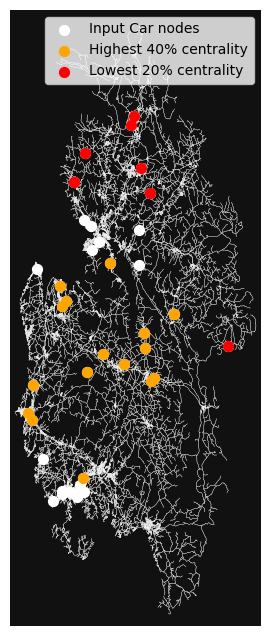

In [10]:
car_nodes_gdf_central = filter_and_plot_nodes_by_centrality(geo_df=car_nodes_gdf, top_percent=0.4, bottom_percent=0.20, input_graph=ost_graph, plot=True)

Input nr of car nodes: 32
Remaining nr of car nodes: 17, after removing the 15 nodes that are within 5000 m of each other



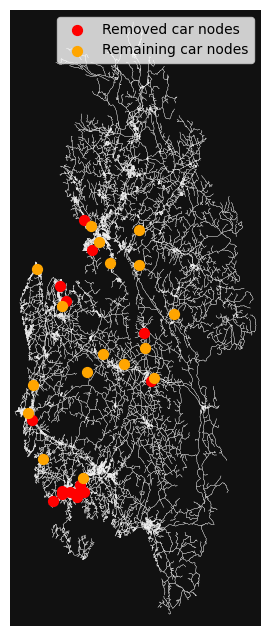

In [11]:
car_nodes_gdf_filtered = filter_nodes_by_proximity(geo_df=car_nodes_gdf_central, min_distance=5000, input_graph=ost_graph, criterion_col='closeness_centrality', prefer='higher', plot=True)

## 2. Simulate event points

Steps:  
2.1 Load preprocessed population data  
2.2 Event simulation based purely on population count. Should fall in range [2000,2500]  
2.3 Snap points to network (after defined Pandana network)  

### 2.1 Load preprocessed population data  

We load preprocessed population data of Øst police district in 250x250m grid cells.
- Correct extent: Akershus and Østfold counties minus Asker, Bærum, Jevnaker and Lunner.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633 before analysis.

In [12]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
ost_polygon_path = "../data/ost/OstCombinedPolygon.geojson"
population_path = "../data/ost/OstPopulation.geojson"
ost_polygon_gdf = gpd.read_file(ost_polygon_path)
population_gdf = gpd.read_file(population_path)
ost_polygon_gdf = ost_polygon_gdf.to_crs(ost_graph.graph['crs']) # convert to same CRS as the road network
population_gdf = population_gdf.to_crs(ost_graph.graph['crs']) # convert to same CRS as the road network
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


,id,population,geometry
0,22735006545750,4,"POLYGON ((273500.000 6545750.000, 273500.000 6..."
1,22737506546000,2,"POLYGON ((273750.000 6546000.000, 273750.000 6..."


In [13]:
# # plot the clipped population data, with the polygon as outline and the population colored by population size
# fig, ax = plt.subplots(figsize=(6,6))
# vmin, vmax = 0, 200
# ost_polygon_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.7)
# population_gdf.plot(ax=ax, column='population', cmap='Reds', legend=True, alpha=0.7, vmin=vmin, vmax=vmax)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.title('Øst police district: Population data')
# plt.tight_layout(); plt.show()

### 2.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range of [2000,2500].

In [14]:
def simulate_event_points(population_gdf, min_range=2000, max_range=2500):
    """
    Simulates the number of event points in each gridcell based on its population count.
    Use a binary search algorithm to find the optimal population multiplier to achieve a target number of points.
    Target range for the total number of points is defined by [min_target, max_target].    
    """
    # Define the target range for the total number of points
    min_target = min_range
    max_target = max_range
    
    # Initial lower and upper bounds for population_multiplier
    low = 0.001
    high = 0.01
    
    # Convergence threshold and maximum iterations to prevent infinite loops
    epsilon = 1e-6
    max_iterations = 100
    iteration = 0
    while iteration < max_iterations:
        mid = (low + high) / 2
        
        # Calculate the number of points using the current guess of population_multiplier
        population_gdf['num_points'] = np.round(mid * population_gdf['population']).astype(int)
        population_gdf['num_points'] = np.maximum(population_gdf['num_points'], 0) # Ensure non-negative
        total_points = population_gdf['num_points'].sum()
        
        # Check if the total number of points is within the target range
        if min_target <= total_points <= max_target:
            print(f"Total number of simulated event points: {total_points}. Target range [{min_target}, {max_target}], using population multiplier: {mid}")
            break
        elif total_points < min_target:
            low = mid
        else:
            high = mid
        
        # Check for convergence
        if abs(high - low) < epsilon:
            print(f"Convergence reached with multiplier: {mid} (total points: {total_points})")
            break
        iteration += 1
    
    if iteration == max_iterations:
        print(f"Max iterations reached with multiplier: {mid} (total points: {total_points})")

    return population_gdf

In [ ]:
# calculate the number of points to simulate in each grid cell - vectorized version
population_gdf = simulate_event_points(population_gdf, min_range=1000, max_range=1500)

# print the number of cells with 0, 1, 2, ..., 9 events
for i in range(0, 6):
    print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 1016. Target range [1000, 1500], using population multiplier: 0.0026875
Nr of cells with 0 events: 24081
Nr of cells with 1 events: 957
Nr of cells with 2 events: 24
Nr of cells with 3 events: 2
Nr of cells with 4 events: 0
Nr of cells with 5 events: 1
Nr of cells with 6 events: 0
Nr of cells with 7 events: 0
Nr of cells with 8 events: 0
Nr of cells with 9 events: 0


,id,population,geometry,num_points
17847,22735006649250,1697,"POLYGON ((273500.000 6649250.000, 273500.000 6...",5
6398,22740006649000,1147,"POLYGON ((274000.000 6649000.000, 274000.000 6...",3
17843,22737506649000,1186,"POLYGON ((273750.000 6649000.000, 273750.000 6...",3


In [16]:
%%time
# Function to generate points within a grid cell
def generate_points_within_gridcell(num_points, bounds):
    """Generate points within given bounds."""
    min_x, min_y, max_x, max_y = bounds
    xs = np.random.uniform(min_x, max_x, num_points)
    ys = np.random.uniform(min_y, max_y, num_points)
    points = [Point(x, y) for x, y in zip(xs, ys)]
    return points

# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell
        points = generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

CPU times: total: 984 ms
Wall time: 1.19 s


,geometry
0,POINT (271283.092 6570224.796)
1,POINT (270844.970 6570523.047)
2,POINT (267929.957 6565194.558)


Total number of simulated event points: 1016


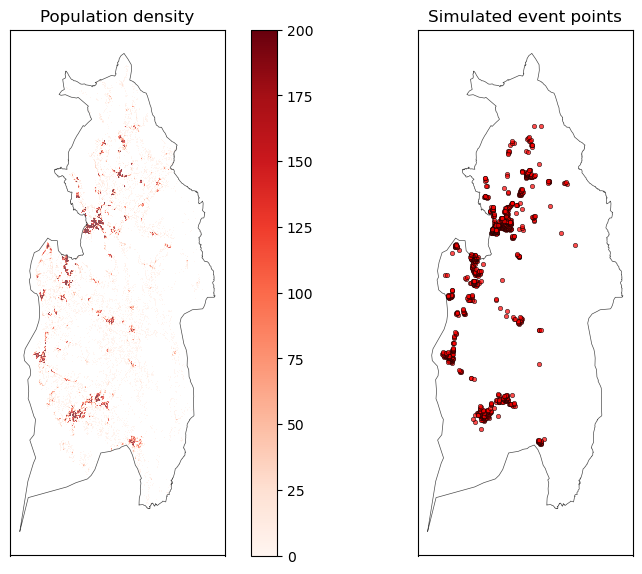

In [17]:
# # 2 subplots side-by-side of population density and simulated event points
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
# vmin, vmax = 0, 200
# ost_polygon_gdf.boundary.plot(ax=ax1, color='black', linewidth=0.5, alpha=0.7)
# population_gdf.plot(ax=ax1, column='population', cmap='Reds', legend=True, alpha=0.7, vmin=vmin, vmax=vmax)
# ax1.get_xaxis().set_visible(False)
# ax1.get_yaxis().set_visible(False)
# ax1.set_title('Population density')

# ost_polygon_gdf.boundary.plot(ax=ax2, color='black', linewidth=0.5, alpha=0.7)
# event_points_gdf.plot(ax=ax2, color='red', markersize=10, alpha=0.7, edgecolor='black', lw=0.5)
# ax2.get_xaxis().set_visible(False)
# ax2.get_yaxis().set_visible(False)
# ax2.set_title('Simulated event points')
# print(f"Total number of simulated event points: {len(event_points_gdf)}")
# plt.tight_layout(); plt.show()

## 3. Define the Pandana network

Now we use the GeoDataFrames from `osmnx` to create a `pandana` network.

Pandana networks is defined like this:   
`pandana.network.Network(node_x, node_y, edge_from, edge_to, edge_weights, twoway=True)`  

 **edge_weights**: DataFrame, all numerics   
- Specifies one or more impedances on the network which define the distances between nodes.  
- Multiple impedances can be used to capture travel times at different times of day, for instance.

We will use both ``length`` and ``travel_time`` as edge weights. However, we must specify which one to use when querying the network (cannot calculate with both at the same time).

In [18]:
# reset index so our origins and destinations are not in index
edges = edges.reset_index()
# nodes = nodes.reset_index()

# create network with pandana
ost_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of ost_network_pdna: {type(ost_network_pdna)}")
print(f"Network nodes:")
ost_network_pdna.nodes_df.head(2)

type of ost_network_pdna: <class 'pandana.network.Network'>
Network nodes:


,x,y
osmid,,
265629056,271942.408,6550299.054
8595477415,271187.495,6549913.134


In [19]:
print(f"Network edges: ")
ost_network_pdna.edges_df.head(2)

Network edges: 


,from,to,length,travel_time
0,265629056,8595477415,1061.374,96.000
1,265629056,8595512022,435.557,31.400


In [20]:
# %%time
# ost_network_pdna.precompute(3000)

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network.   
Therefore, we need to snap the event points to the Pandana network.

In [21]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = ost_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

,geometry,nearest_node,x,y
0,POINT (271283.092 6570224.796),1105751020.000,271300.581,6570222.632
1,POINT (270844.970 6570523.047),446363052.000,270811.664,6570526.252


In [22]:
# Get list of nearest node ids for event locations
event_nodes_pdna = ost_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = ost_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([5796201937, 2634837196, 4455422778, 5851459453, 8121476636],
      dtype=int64)

In [23]:
# # converting the event nodes to a geodataframe
# event_nodes_snap_gdf = gpd.GeoDataFrame(geometry=[Point(ost_network_pdna.nodes_df.loc[node, 'x'], ost_network_pdna.nodes_df.loc[node, 'y']) for node in event_points_gdf], crs="EPSG:32633")
# event_nodes_snap_gdf.head(2)

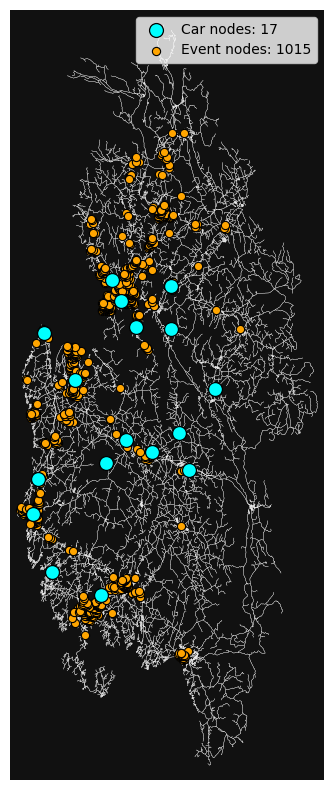

In [24]:
# Plot nodes for overview using ox.plot
fig, ax = ox.plot_graph(ost_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
# add number of events and car nodes to the legend
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
ax.legend(); plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

First, identify the nearest node to each Police car and Event.
- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)

In [25]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [26]:
%%time
# distance between each possible pair of facilities-clients combination
distances = ost_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = ost_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')

print(type(distances))
print("Number of distances calculated: ", len(distances), "\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5], "\n")

<class 'list'>
Number of distances calculated:  17255 

5 first origin-destination distances [m]     : [57995.67, 57184.985, 61220.805, 58170.853, 57786.371]
5 first origin-destination travel times [sec]: [2815.6, 2872.2, 3112.2, 2964.2, 2949.9] 

CPU times: total: 781 ms
Wall time: 108 ms


In [27]:
# print the statistics for distances and travel times
# print("Distances statistics:")
# print(pd.Series(distances).describe())
print("\nTravel times statistics:")
print(pd.Series(travel_times).describe())


Travel times statistics:
count   17255.000
mean     3058.542
std      1562.638
min         9.800
25%      1759.899
50%      3088.900
75%      4267.800
max      7282.200
dtype: float64


In [28]:
# Restructure the distances and travel times arrays into a DataFrame (Cost Matrix) and add the car and event node ids as columns

# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix.head(2)

,distance,travel_time,carNodeID,eventNodeID
0,57995.670,2815.600,5796201937,1105751020
1,57184.985,2872.200,5796201937,446363052


In [29]:
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

,distance,travel_time,carNodeID,eventNodeID,x,y
0,57995.670,2815.600,5796201937,1105751020,271300.581,6570222.632
1,57184.985,2872.200,5796201937,446363052,270811.664,6570526.252


In [30]:
# Save cost matrix to CSV
CostMatrix.to_csv("../data/ost/OstCostMatrix.csv", index=False)

# # import cost matrix from CSV
# CostMatrix_imported = pd.read_csv("../data/ost/OstCostMatrix.csv")
# CostMatrix_imported.head(2)

CostMatrix.drop(columns="distance", inplace=True)

Now, we have made Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

### Notation

Let's define the notation that will be used to formulate the problem:
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events, each associated with a node in $N$ and a severity score.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.

### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M_i \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data structures for efficient computation

In [31]:
# CostMatrix = CostMatrix.reset_index(drop=True)

# Remove duplicates while keeping the first occurrence
CostMatrix_unique = CostMatrix.drop_duplicates(subset=['carNodeID', 'eventNodeID'], keep='first')

# Convert to a dictionary for fast lookup
CostMatrix_dict = CostMatrix_unique.set_index(['carNodeID', 'eventNodeID'])['travel_time'].to_dict()

### 5.2 Setup LP problem

In [32]:
# Constants
K = 4  # Number of police car locations in final solution
M = 280   # Maximum number of events a single police car can respond to

# Sets
P = CostMatrix['carNodeID'].unique()  # Potential police car locations
E = CostMatrix['eventNodeID'].unique()  # Events

# Create the LP object - minimize total travel time
problem = pulp.LpProblem("PoliceCarLocationOptimization", pulp.LpMinimize) # Minimization problem
problem

PoliceCarLocationOptimization:
MINIMIZE
None
VARIABLES

### 5.3 Add decision variables and objective function

In [33]:
%%time
# Decision Variables
# x[i] = 1 if a police car is placed at location i, 0 otherwise
x = pulp.LpVariable.dicts("x", P, cat='Binary')  # Police car placement

# # y[i, j] = 1 if event j is assigned to police car i, 0 otherwise
y = pulp.LpVariable.dicts("y", [(i, j) for i in P for j in E], cat='Binary')  # Event assignment

# Objective Function - Modified to use CostMatrix_dict for fast lookup
problem += pulp.lpSum([CostMatrix_dict[(i, j)] * y[(i, j)] for i in P for j in E if (i, j) in CostMatrix_dict]), "TotalResponseTime"

CPU times: total: 422 ms
Wall time: 611 ms


### 5.4 Add problem constraints

In [34]:
# %%time
# Police Car Placement Constraint
problem += pulp.lpSum([x[i] for i in P]) == K, "NumberOfPoliceCars"

# Event Assignment Constraint
for j in E:
    problem += pulp.lpSum([y[(i, j)] for i in P]) == 1, f"EventAssignment_{j}"

# Validity Constraint
for i in P:
    for j in E:
        problem += y[(i, j)] <= x[i], f"Validity_{i}_{j}"

# Capacity Constraint
for i in P:
    problem += pulp.lpSum([y[(i, j)] for j in E]) <= M * x[i], f"Capacity_{i}"

### 5.5 Run the solvers

- **PULP_CBC (COIN-OR Branch and Cut)** - default solver in PuLP. It is an open-source solver that is included in the PuLP package. It is a branch-and-cut solver that uses the COIN-OR CBC optimization engine.

- **HiGHS (High-Performance Solver)** - a high-performance solver that use the HiGHS optimization engine. It has been designed to solve large-scale linear programming problems and is particularly well-suited for solving problems with a large number of constraints and variables. Can use multiple threads to significantly speed up the solution process for complex problems. 


#### Solver configuration:
**``mip=True``** - signals solver to use algorithms and heuristics designed for integer constraints, ensuring that the solution adheres to the binary variable requirements. However, ``mip=False`` can relax the integer constraints and simplify the solution space for optimization algorithms to navigate. Can sometimes be faster, but result needs to be inspected, as they might be invalid.

1st run of each solver will relax the integer variable constraint (`mip=False`) for fast computation.  
2ns run of each solver will use proper integer constraints (`mip=True`) to get the slow, final solution for verification.

Note: relaxing integer constraints can drastically reduce complexity and, consequently, the solving time. This is expected behavior as integer programming problems are generally NP-hard, while their linear programming counterparts (with relaxed integer constraints) can be solved in polynomial time.

*Recall this is a minimization problem, so the lower the objective value, the better the solution.*

In [35]:
# Inspect available pulp solvers
pulp.listSolvers(onlyAvailable=True)

['GLPK_CMD', 'PULP_CBC_CMD', 'COIN_CMD', 'HiGHS']

#### 5.5.1 PULP_CBC (COIN-OR Branch and Cut) Solver

In [36]:
%%time
# PULP CBC VERSION 1: mip=False
status = problem.solve(pulp.PULP_CBC_CMD(mip=False, msg=False))
# cbc_status_mip_false = problem.solve(pulp.PULP_CBC_CMD(mip=False,msg=False,gapRel=0.9,warmStart=True,strong=True,cuts=True,options=['presolve','on']))
### extra arguments other than mip=True/False did not show any significant difference in runtime

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.4f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")
cbc_optimal_locations_mipF = np.array([i for i in P if x[i].varValue == 1])
cbc_solTime_mipF = problem.solutionTime

print(f"Optimal police car locations (LP)  : {cbc_optimal_locations_mipF}), found in {cbc_solTime_mipF:.2f} seconds")

status: 1, Optimal
Objective function value: 697892.7316 seconds, or 11631.55 minutes, or 193.86 hours
Optimal police car locations (LP)  : [1303773676 1068403788]), found in 1.53 seconds
CPU times: total: 375 ms
Wall time: 1.57 s


In [37]:
%%time
# PULP CBC VERSION 2: mip=True
# status = problem.solve(pulp.PULP_CBC_CMD(mip=True, msg=False))
status = problem.solve(pulp.PULP_CBC_CMD(mip=True,msg=False,gapRel=0.1,warmStart=True,strong=True,cuts=True,options=['presolve','on']))
### extra arguments other than mip=True/False did not show any significant difference in runtime

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.4f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")
cbc_optimal_locations_mipT = np.array([i for i in P if x[i].varValue == 1])
cbc_solTime_mipT = problem.solutionTime

print("\nCompare if the relaxed LP solution is equivalent to the MILP solution =", np.array_equal(cbc_optimal_locations_mipF, cbc_optimal_locations_mipT))
print(f"Optimal police car locations (LP)  : {cbc_optimal_locations_mipF}), found in {cbc_solTime_mipF:.2f} seconds")
print(f"Optimal police car locations (MILP): {cbc_optimal_locations_mipT}), found in {cbc_solTime_mipT:.2f} seconds")

status: 1, Optimal
Objective function value: 710877.2940 seconds, or 11847.95 minutes, or 197.47 hours

Compare if the relaxed LP solution is equivalent to the MILP solution = False
Optimal police car locations (LP)  : [1303773676 1068403788]), found in 1.53 seconds
Optimal police car locations (MILP): [1303773676 1068403788  901799182    3173240]), found in 6.98 seconds
CPU times: total: 328 ms
Wall time: 6.99 s


#### 5.5.2 COIN_CMD (COIN-OR Clp/Cbc Solver) Solver

In [38]:
%%time
# COIN_CMD VERSION 1: mip=False
status = problem.solve(pulp.COIN_CMD(mip=False, msg=False))
# cbc_status_mip_false = problem.solve(pulp.COIN_CMD(mip=False,msg=False,gapRel=0.9,warmStart=True,strong=True,cuts=True,options=['presolve','on']))
### extra arguments other than mip=True/False did not show any significant difference in runtime

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.4f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")
cbc_optimal_locations_mipF = np.array([i for i in P if x[i].varValue == 1])
cbc_solTime_mipF = problem.solutionTime

status: 1, Optimal
Objective function value: 697892.7316 seconds, or 11631.55 minutes, or 193.86 hours
CPU times: total: 328 ms
Wall time: 1.49 s


In [39]:
%%time
# COIN_CMD VERSION 2: mip=True
status = problem.solve(pulp.COIN_CMD(mip=True, msg=False))

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.4f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")
cbc_optimal_locations_mipT = np.array([i for i in P if x[i].varValue == 1])
cbc_solTime_mipT = problem.solutionTime

print("\nCompare if the relaxed LP solution is equivalent to the MILP solution =", np.array_equal(cbc_optimal_locations_mipF, cbc_optimal_locations_mipT))
print(f"Optimal police car locations (LP)  : {cbc_optimal_locations_mipF}), found in {cbc_solTime_mipF:.2f} seconds")
print(f"Optimal police car locations (MILP): {cbc_optimal_locations_mipT}), found in {cbc_solTime_mipT:.2f} seconds")

status: 1, Optimal
Objective function value: 710877.2940 seconds, or 11847.95 minutes, or 197.47 hours

Compare if the relaxed LP solution is equivalent to the MILP solution = False
Optimal police car locations (LP)  : [1303773676 1068403788]), found in 1.48 seconds
Optimal police car locations (MILP): [1303773676 1068403788  901799182    3173240]), found in 10.30 seconds
CPU times: total: 344 ms
Wall time: 10.3 s


#### 5.5.3 GLPK (GNU Linear Programming Kit) Solver

In [40]:
%%time
# GLPK Solver: VERSION 1: mip=False
# status = problem.solve(pulp.GLPK_CMD(mip=False, msg=False)
status = problem.solve(pulp.GLPK_CMD(
    mip=False,  # mip=True since have binary variables. mip=False can sometimes be faster, but result might be invalid
    msg=False,  # Display solver output for more insight
    timeLimit=120,  # Solver time limit set to X seconds
    options=['--presol', '--cuts', '--mipgap', '0.1']
))

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.4f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")
glpk_optimal_locations_mipF = np.array([i for i in P if x[i].varValue == 1])
glpk_solTime_mipF = problem.solutionTime


status: 1, Optimal
Objective function value: 697892.8308 seconds, or 11631.55 minutes, or 193.86 hours
CPU times: total: 359 ms
Wall time: 9.77 s


In [41]:
# %%time # cancelled at 40+ min
# GLPK Solver: VERSION 2: mip=True
# status = problem.solve(pulp.GLPK_CMD(mip=True, msg=False))

# # inspect the status of the solution
# print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
# print(f"Objective function value: {pulp.value(problem.objective):.4f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")
# glpk_optimal_locations_mipT = np.array([i for i in P if x[i].varValue == 1])
# glpk_solTime_mipT = problem.solutionTime

# print("\nCompare if the relaxed LP solution is equivalent to the MILP solution =", np.array_equal(glpk_optimal_locations_mipF, glpk_optimal_locations_mipT))
print(f"Optimal police car locations (LP)  : {glpk_optimal_locations_mipF}), found in {glpk_solTime_mipF:.2f} seconds")
# print(f"Optimal police car locations (MILP): {glpk_optimal_locations_mipT}), found in {glpk_solTime_mipT:.2f} seconds")

Optimal police car locations (LP)  : [1303773676 1068403788]), found in 9.74 seconds


#### 5.5.4 HiGHS (High-Performance Solver) Solver

In [42]:
%%time
# HiGHS Solver: VERSION 1: mip=False
status = problem.solve(pulp.HiGHS(mip=False, msg=False, parallel="on"))
# status = problem.solve(pulp.HiGHS(mip=False, msg=False,msg=False,presolve="on",warmstart=True,
#     parallel="on",mip_allow_restart="True",mip_heuristic_effort=0.1,mip_rel_gap=0.0000001,
#     timeLimit=60,threads=6,options=["presolve=on", "simplex_strategy=4"]))
### other extra arguments did not show any significant difference in runtime

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.4f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")
highs_optimal_locations_mipF = np.array([i for i in P if x[i].varValue == 1])
highs_solTime_mipF = problem.solutionTime

status: 1, Optimal
Objective function value: 697892.7318 seconds, or 11631.55 minutes, or 193.86 hours
CPU times: total: 2.92 s
Wall time: 1.09 s


In [43]:
%%time
# HiGHS Solver: VERSION 2: mip=True
# status = problem.solve(pulp.HiGHS(mip=True, msg=False, parallel="on"))
status = problem.solve(pulp.HiGHS(mip=True, msg=False,presolve="on",warmstart=True,
    parallel="on",mip_allow_restart="True",mip_heuristic_effort=0.1,mip_rel_gap=0.01,
    timeLimit=60,options=["presolve=on", "simplex_strategy=4"]))
### other extra arguments did not show any significant difference in runtime

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.4f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")
highs_optimal_locations_mipT = np.array([i for i in P if x[i].varValue == 1])
highs_solTime_mipT = problem.solutionTime

print("\nCompare if the relaxed LP solution is equivalent to the MILP solution =", np.array_equal(highs_optimal_locations_mipF, highs_optimal_locations_mipT))
print(f"Optimal police car locations (LP)  : {highs_optimal_locations_mipF}), found in {highs_solTime_mipF:.2f} seconds")
print(f"Optimal police car locations (MILP): {highs_optimal_locations_mipT}), found in {highs_solTime_mipT:.2f} seconds")

status: 1, Optimal
Objective function value: 710877.2940 seconds, or 11847.95 minutes, or 197.47 hours

Compare if the relaxed LP solution is equivalent to the MILP solution = False
Optimal police car locations (LP)  : [1303773676 1068403788]), found in 1.08 seconds
Optimal police car locations (MILP): [1303773676 1068403788  901799182    3173240]), found in 13.99 seconds
CPU times: total: 11.7 s
Wall time: 14 s


#### Comparison of the solvers:


All solvers found the same optimal solution for the minimal objective value. However, computation time and optimal locations varied between the solvers.

PULP_CBC(pulp included), COIN_CMD(binary install) and GLPK found the same 4 optimal locations, when solving the problem both as a relaxed LP problem and as a MILP problem. PULP_CBC and COIN_CMD was equally the fastest, while GLPK was slower. 

The HiGHS solver was faster to solve the problem in both cases. However, it only found 1 optimal location when solving as a relaxed LP problem and 0 when solving as a MILP problem.



In [44]:
# Choose the optimal police car locations from the best performing solver
optimal_police_locations = cbc_optimal_locations_mipT # typically stable results
# optimal_police_locations = glpk_optimal_locations_mipT
# optimal_police_locations = highs_optimal_locations_mipF
optimal_police_locations

array([1303773676, 1068403788,  901799182,    3173240], dtype=int64)

### 5.6 Extract results for inspection

In [45]:
# Extracting optimal police car locations
# optimal_police_locations = [i for i in P if x[i].varValue == 1]
optimal_police_locations_gdf = gpd.GeoDataFrame(geometry=[Point(ost_network_pdna.nodes_df.loc[node, 'x'], ost_network_pdna.nodes_df.loc[node, 'y']) for node in optimal_police_locations], crs="EPSG:32633")

# export optimal_police_car_locations_gdf to CSV
optimal_police_locations_gdf.to_csv('../data/ost/OstOptimalLocations.csv', index=False)

# Extracting results
results = []
for i in P:
    for j in E:
        if pulp.value(y[(i, j)]) == 1:
            results.append({'carNodeID': i, 'eventNodeID': j})

# Creating a DataFrame from the results
results_df = pd.DataFrame(results)

# Merging with CostMatrix_extended to add distance, travel_time, and coordinates
results_df = pd.merge(results_df, CostMatrix_extended[['carNodeID', 'eventNodeID', 'distance', 'travel_time', 'x', 'y']], on=['carNodeID', 'eventNodeID'], how='left')
results_df.head(3)

,carNodeID,eventNodeID,distance,travel_time,x,y
0,1303773676,3849319461,35882.133,1594.400,256106.501,6601779.523
1,1303773676,8630098784,35712.691,1602.700,256097.639,6601942.060
2,1303773676,8630098738,35645.538,1569.100,256292.466,6601788.734


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 17 | Optimal locations in solution: 4
- Events: 1015 | Max event capacity per police car: 280

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 710877 sec | 11848.0 min | 197.47 hours

Police car id: 1303773676 handles 241 events | Capacity: 86.07% | Total response time: 3253.67 min | Avg response time: 13.50 min
Police car id: 1068403788 handles 280 events | Capacity: 100.00% | Total response time: 4184.36 min | Avg response time: 14.94 min
Police car id: 901799182 handles 268 events | Capacity: 95.71% | Total response time: 1605.15 min | Avg response time: 5.99 min
Police car id: 3173240 handles 226 events | Capacity: 80.71% | Total response time: 2974.55 min | Avg response time: 13.16 min


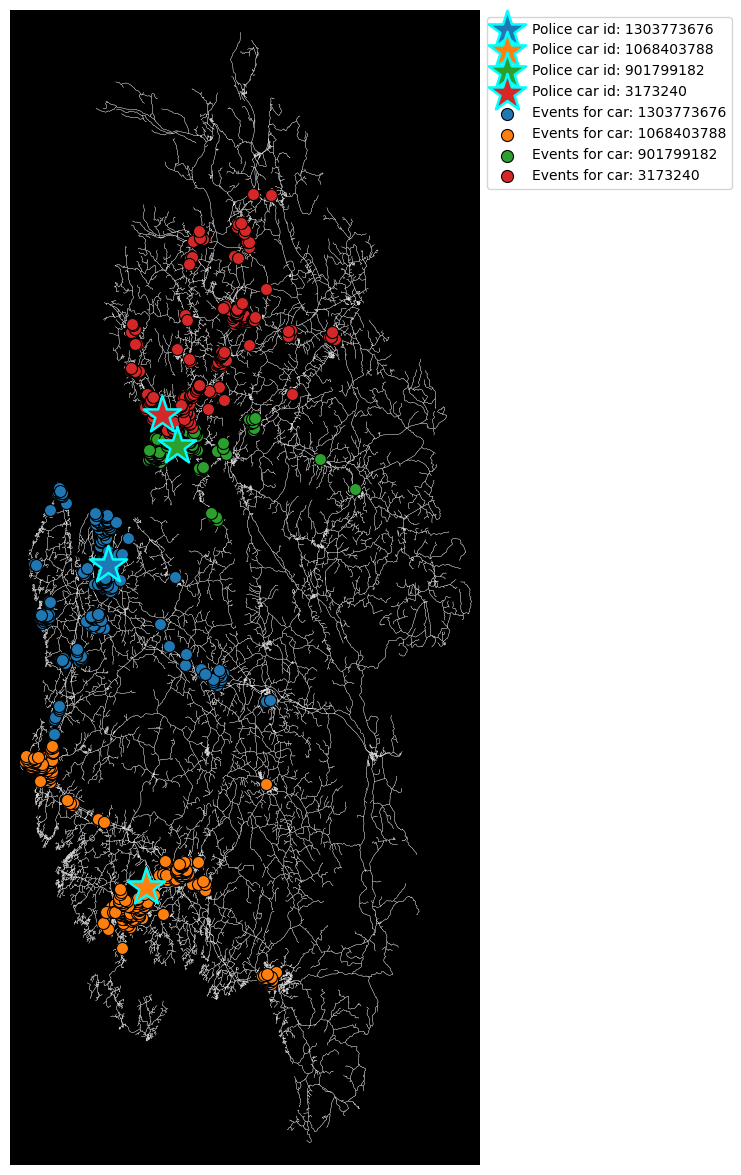

CPU times: total: 5.41 s
Wall time: 6.83 s


In [ ]:
%%time 
# plot the optimal police car locations and the events assigned to them
fig, ax = ox.plot_graph(ost_graph, node_color="white", node_size=0, bgcolor='k', edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))

# Plotting optimal police car locations
# Assuming 'x' and 'y' in CostMatrix_extended are in UTM coordinates
# colors = ['cyan', 'magenta', 'yellow', 'green']
for i, police_car in enumerate(optimal_police_locations_gdf.index):
    police_car_id = optimal_police_locations[i]
    ax.scatter(optimal_police_locations_gdf.loc[police_car, 'geometry'].x, optimal_police_locations_gdf.loc[police_car, 'geometry'].y, c=f'C{i}', marker='*', edgecolor='cyan', linewidth=1.8, s=800, label=f"Police car id: {police_car_id}", zorder=3)

# Plotting events assigned to each optimal police car
for car_id in optimal_police_locations:
    assigned_events = results_df[results_df['carNodeID'] == car_id]
    event_coords = list(zip(assigned_events['y'], assigned_events['x']))
    ax.scatter([x for _, x in event_coords], [y for y, _ in event_coords], s=75, edgecolor='black', lw=0.80, label=f'Events for car: {car_id}', zorder=2)

# Enhance legend to avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# place legend outside in box on right side
plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.0, 1))

print("Input parameters:")
print(f"- Possible police car locations: {len(car_nodes_gdf_filtered)} | Optimal locations in solution: {K}")
print(f"- Events: {len(event_points_gdf)} | Max event capacity per police car: {M}\n")

print("Solution from Linear Programming (LP) model:")
print(f"Goal: minimize objective function (total response time)")
print(f"Objective function value: {pulp.value(problem.objective):.0f} sec | {pulp.value(problem.objective)/60:.1f} min | {pulp.value(problem.objective)/3600:.2f} hours\n")

for car_id in results_df['carNodeID'].unique():
    assigned_events = results_df[results_df['carNodeID'] == car_id]
    total_events = len(assigned_events)
    total_response_time = assigned_events['travel_time'].sum() / 60 # convert to minutes
    avg_response_time = assigned_events['travel_time'].mean()  / 60 # convert to minutes
    capacity_usage = (total_events / M) * 100
    
    print(f"Police car id: {car_id} handles {total_events} events | Capacity: {capacity_usage:.2f}% | Total response time: {total_response_time:.2f} min | Avg response time: {avg_response_time:.2f} min")

plt.show()

## 6.2 Visualize Isochrones - How far can you drive in different time intervals?
How far can you drive in 1.5, 4 and 8 minutes from the origin nodes? We'll use NetworkX to induce a subgraph of gruner_graph within each distance, based on travel time.  
We also, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [47]:
# Define how many trip times to visualize
TRIP_TIMES = [15, 30, 45]  # in minutes
ISO_COLORS = ['blue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [48]:
# Create isochrone polygons
def make_iso_polys(G, center_nodes, edge_buff=30, node_buff=0, infill=True):
    """
    Generate isochrone polygons for given center nodes in a graph.
    """
    all_isochrone_polys = []
    for center_node in center_nodes:
        isochrone_polys = []
        for trip_time in sorted(TRIP_TIMES, reverse=True):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time*60, distance='travel_time')
            if subgraph.number_of_nodes() == 0 or subgraph.number_of_edges() == 0:
                # Skip if subgraph is empty
                continue
            
            # Mapping node IDs to Points
            node_id_to_point = {node: Point(data['x'], data['y']) for node, data in subgraph.nodes(data=True)}
            
            edge_lines = []
            for n_from, n_to in subgraph.edges():
                f_point = node_id_to_point[n_from]
                t_point = node_id_to_point[n_to]
                edge_lines.append(LineString([f_point, t_point]))

            # Buffer nodes and edges, then combine
            n = gpd.GeoSeries([node_id_to_point[node] for node in subgraph.nodes()]).buffer(node_buff)
            e = gpd.GeoSeries(edge_lines).buffer(edge_buff)
            all_gs = list(n) + list(e)
            new_iso = gpd.GeoSeries(all_gs).unary_union
            
            # Handling infill
            if infill and isinstance(new_iso, Polygon):
                new_iso = Polygon(new_iso.exterior)
                
            isochrone_polys.append(new_iso)
        all_isochrone_polys.append(isochrone_polys)
    return all_isochrone_polys

In [49]:
# Merge isochrones to prevent overlap
def merge_isochrones(G, isochrone_polys):
    """
    Merge isochrones to prevent overlap.
    """
    # Initialize containers for merged isochrones by range
    merged_short = []; merged_middle = []; merged_long = []

    # Populate the lists with polygons to merge
    for location_polygons in isochrone_polys:
        if len(location_polygons) >= 1:
            merged_short.append(location_polygons[0])  # Assuming first is short-range
        if len(location_polygons) >= 2:
            merged_middle.append(location_polygons[1])  # Assuming second is middle-range
        if len(location_polygons) == 3:
            merged_long.append(location_polygons[2])  # Assuming third is long-range

    # Perform the merging
    merged_short_union = unary_union(merged_short)
    merged_middle_union = unary_union(merged_middle)
    merged_long_union = unary_union(merged_long)
    return merged_short_union, merged_middle_union, merged_long_union

Isochrone polygons for the travel times: [15, 30, 45] minutes


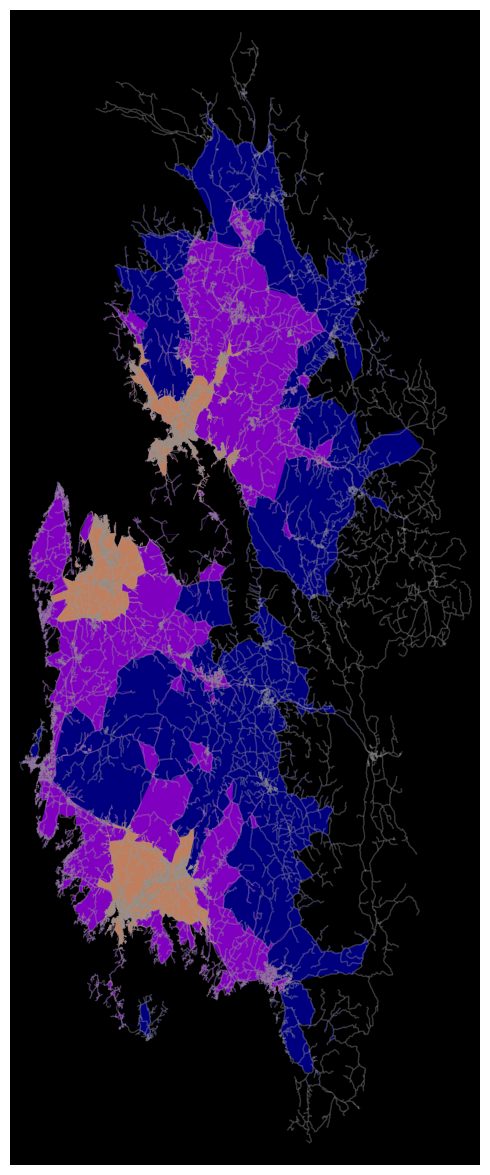

CPU times: total: 2min 32s
Wall time: 2min 59s


In [50]:
%%time
# Generate isochrone polygons
isochrone_polys = make_iso_polys(ost_graph, optimal_police_locations)

# Merge isochrones
merged_isochrones = merge_isochrones(ost_graph, isochrone_polys)

# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(ost_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
# iso_colors = ['blue', 'magenta', 'yellow']  # Long, Middle, Short ranges
for merged_poly, color in zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS):
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=0.5, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=0.5, zorder=-1)
        ax.add_patch(patch)

print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

In [51]:
%%time
# reverse order of trip_times
TRIP_TIMES.sort(reverse=True)

# Prepare data for GeoDataFrame
data = {
    'trip_time': TRIP_TIMES,
    'geometry': [merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]]
}
# Convert dictionary to GeoDataFrame
crs_proj = ox.graph_to_gdfs(ost_graph, nodes=False).crs  # Adjusted to explicitly state nodes=False
isochrones_gdf = gpd.GeoDataFrame(data, crs=crs_proj)

# Visualize the merged isochrones on a Leaflet map
leaflet_map = isochrones_gdf.explore(
    column='trip_time',  # trip_time column to differentiate the isochrones
    cmap='RdPu',  # color map
    tiles='OpenStreetMap',  # 'OpenStreetMap' for light tiles, 'CartoDB dark_matter' for dark tiles
    style_kwds={'fillOpacity': 0.35, 'lineOpacity': 0.7},  # Adjust opacities as needed
    legend=True,  # Legend to differentiate ranges
    tooltip=True  # Display trip times on hover
)

# Add background polygon to outline police district, but loose hover-legend functionality
folium.GeoJson(
    ost_polygon_gdf.geometry,
    style_function=lambda x: {'color': 'black', 'weight': 0.5, 'fillOpacity': 0.1, 'lineOpacity': 0.7}
).add_to(leaflet_map)

leaflet_map

CPU times: total: 2 s
Wall time: 2.39 s
